# Analyze the behavior of liquidators.

Steps:
1. Load a sample of events from the Google Storage for each of the following protocols: "zklend", "nostra_alpha", "nostra_mainnet", "hashstack_v0", and "hashstack_v1". You can find the sample e.g. for zkLend here: https://storage.googleapis.com/derisk-persistent-state/zklend_data/events_sample.parquet. To obtain the sample for other protocols, just change the folder in the address, e.g. https://storage.googleapis.com/derisk-persistent-state/nostra_alpha_data/events_sample.parquet for Nostra Alpha. Write the loading part in a way that the source can be easily changed from the Google Storage to a local database.
2. Identify only liquidation events. Use Starkscan to explore their structure. For example, this is one of zkLend's liquidation events. https://starkscan.co/event/0x00a1e829fb091f7493c509135992ac12af6a81177e3ffab5c34951fb29c23084_6
3. Identify the amounts of debt tokens liquidated.
4. Visualize the behavior of all liquidators found in the sample in a Jupyter notebook. You should use the visualizations to answer the following questions:

How many liquidators are there per protocol? Do some of them operate on more than just a single lending protocol?

How many loans has each of them liquidated?

What is the average liquidated debt amount? Compute the averages across all liquidations, but also per protocol and per token amounts.

What is the total amount of the liquidated debt? Compute the total amounts across all liquidations, but also per protocol and per token amounts.

Fetch prices for these tokens (in USD), e.g., from Coingecko. Multiply the token amounts by the corresponding prices to obtain USD nominal amounts and be able to compare the per token stats across tokens.

In [1]:
# Standard library imports
import json
import sys

# 3rd party imports
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import yfinance as yf
    
# Local imports
sys.path.append('..')

# # Environment variable setting
%env PG_CONNECTION_STRING=''  # nostra_mainnet.py has dependencies. To avoid error adding a dummy env
import src.db
from src.nostra_alpha import ADDRESSES_TO_TOKENS as nostra_alpha_tokens
from src.nostra_mainnet import ADDRESSES_TO_TOKENS as nostra_mainnet_tokens

env: PG_CONNECTION_STRING=''  # nostra_mainnet.py has dependencies. To avoid error adding a dummy env


In [2]:
def load_protocol_data(protocols: list[str]) -> pd.DataFrame:
    """
    Load data from Google Storage for the specified protocols and combine them into a single DataFrame.
    
    Parameters:
    protocols (list[str]): A list of protocol names to load data for.
    
    Returns:
    pd.DataFrame: A DataFrame containing the combined data from all specified protocols.
    
    """    
    combined_protocols_df = pd.DataFrame()
    
    for protocol in protocols:
        # Read from google storage
        url = f"https://storage.googleapis.com/derisk-persistent-state/{protocol}_data/events_sample.parquet"      
        print(f"Processing {protocol} from Google Storage...")
        df_protocol = pd.read_parquet(url)
        
        # Read from SQL DB
        ## Uncomment the following code block and comment the above three lines to load data from a local database
        # connection = src.db.establish_connection()
        # query = f"SELECT * FROM {protocol}_data" # Ensure table name is correct
        # print(f"Processing {protocol} from local database...")
        # df_protocol = pd.read_sql(query, con = connection)
        # connection.close()
        
        df_protocol['Protocol'] = protocol
        combined_protocols_df = pd.concat([combined_protocols_df, df_protocol], ignore_index=True)
    return combined_protocols_df

# List of protocols
PROTOCOLS = ['zklend', 'nostra_alpha', 'nostra_mainnet', 'hashstack_v0', 'hashstack_v1']

# Load the data
combined_protocols_df = load_protocol_data(PROTOCOLS)
print(f"Combined dataframe shape: {combined_protocols_df.shape}")

Processing zklend from Google Storage...
Processing nostra_alpha from Google Storage...
Processing nostra_mainnet from Google Storage...
Processing hashstack_v0 from Google Storage...
Processing hashstack_v1 from Google Storage...
Combined dataframe shape: (305033, 11)


In [3]:
# 1. ZKLEND
# Liquidation events for the zklend protocol
filtered_df_zklend = combined_protocols_df.loc[
    (combined_protocols_df['Protocol'] == 'zklend') & 
    (combined_protocols_df["key_name"] == 'Liquidation')]

def get_zkLend_liquidation_data(row: pd.Series) -> pd.Series:
    """
    Extracts liquidation data for zkLend protocol from a given row.

    Parameters:
    row (pd.Series): A row from the DataFrame containing event data.

    Returns:
    pd.Series: The updated row with extracted liquidation data.
    """
    
    row['liquidator'] = json.loads(row['data'])[0]
    row['debt_token'] = json.loads(row['data'])[2]
    row['debt_face_amount'] = json.loads(row['data'])[4]
    return row

filtered_df_zklend = filtered_df_zklend.apply(get_zkLend_liquidation_data, axis=1)

In [4]:

# 2. Nostra_alpha 
# Under Nostra, liquidations should be composed of at least 2 Burn events, 
# 1 Burn event for the collateral token and  1 Burn event for the debt token. 
# Both events should have the same user and occur within the same block_number and`transaction_hash`. 

# Load the dataframe
df = combined_protocols_df.loc[(combined_protocols_df['Protocol'] == 'nostra_alpha')]

def get_nostra_liquidation_data(row: pd.Series) -> pd.Series:
    """
    Extracts liquidation data for nostra_alpha protocol from a given row.

    Parameters:
    row (pd.Series): A row from the DataFrame containing event data.

    Returns:
    pd.Series: The updated row with extracted liquidation data.
    """
    
    row['user'] = json.loads(row['data'])[0]
    row['amount'] = json.loads(row['data'])[1]
    return row

# Filter out the burn events
burn_events = df[df["key_name"] == 'Burn']

tqdm.pandas()
burn_events = burn_events.progress_apply(get_nostra_liquidation_data, axis=1)

100%|██████████| 14234/14234 [00:11<00:00, 1269.63it/s]


In [5]:
# Separate collateral and debt burn events
nostra_burn_collateral = burn_events[burn_events['from_address'].isin([addr for addr, event in nostra_alpha_tokens.items() if 'collateral' in event])]
nostra_burn_debt = burn_events[burn_events['from_address'].isin([addr for addr, event in nostra_alpha_tokens.items() if event == 'debt'])]

# Merge collateral and debt events on user, block_number, and transaction_hash
merged_burn_events = pd.merge(
    nostra_burn_collateral,
    nostra_burn_debt,
    on=['user', 'block_number', 'transaction_hash'],
    suffixes=('_collateral', '_debt')
)

# Display the filtered dataframe
filtered_df_nostra_alpha = merged_burn_events

# No liquidations found, i.e. the transaction_hash doesnt match for the burn events. Therefore, cannot be categorised
# as liquidation event 

# Create dummy columns for nostra_alpha.Once we have liquidations data, the following lines must be
# replaced by real values 
required_columns = ['timestamp', 'debt_token', 'liquidator', 'debt_face_amount', 'Protocol']

for col in required_columns:
    if col not in filtered_df_nostra_alpha.columns:
        filtered_df_nostra_alpha[col] = None

In [6]:
# 3. Nostra_mainnet 
# Under Nostra, liquidations should be composed of at least 2 Burn events, 
# 1 Burn event for the collateral token and  1 Burn event for the debt token. 
# Both events should have the same user and occurr within the same block_number and`transaction_hash`. 

# Load the dataframe
df = combined_protocols_df.loc[(combined_protocols_df['Protocol'] == 'nostra_mainnet')]

def get_nostra_mainnet_liquidation_data(row: pd.Series) -> pd.Series:
    """
    Extracts liquidation data for nostra_mainnet protocol from a given row.

    Parameters:
    row (pd.Series): A row from the DataFrame containing event data.

    Returns:
    pd.Series: The updated row with extracted liquidation data.
    """
    row['user'] = json.loads(row['data'])[0]
    row['amount'] = json.loads(row['data'])[1]
    return row

# Filter out the burn events
burn_events = df[df["key_name"] == 'Burn']

tqdm.pandas()
burn_events = burn_events.progress_apply(get_nostra_mainnet_liquidation_data, axis=1)

100%|██████████| 17779/17779 [00:14<00:00, 1211.74it/s]


In [7]:
# Separate collateral and debt burn events
nostra_burn_collateral = burn_events[burn_events['from_address'].isin([addr for addr, event in nostra_mainnet_tokens.items() if 'collateral' in event])]
nostra_burn_debt = burn_events[burn_events['from_address'].isin([addr for addr, event in nostra_mainnet_tokens.items() if event == 'debt'])]

# Merge collateral and debt events on user, block_number, and transaction_hash
merged_burn_events = pd.merge(
    nostra_burn_collateral,
    nostra_burn_debt,
    on=['user', 'block_number', 'transaction_hash'],
    suffixes=('_collateral', '_debt')
)

# Display the filtered dataframe
filtered_df_nostra_mainnet = merged_burn_events

# No liquidations found, i.e. the transaction_hash doesnt match for the burn events. Therefore, cannot be categorised
# as liquidation event

# Create dummy columns for nostramainnet.Once we have liquidations data, the following lines must be
# replaced by real values
required_columns = ['timestamp', 'debt_token', 'liquidator', 'debt_face_amount', 'Protocol']

for col in required_columns:
    if col not in filtered_df_nostra_mainnet.columns:
        filtered_df_nostra_mainnet[col] = None

In [8]:
# 4. hashstack_v0

# Liquidation events for the hashstack_v0 protocol
filtered_df_hashstack_v0 = combined_protocols_df.loc[
    (combined_protocols_df['Protocol'] == 'hashstack_v0') & 
    (combined_protocols_df["key_name"] == 'liquidated')]

def get_hashstackv0_liquidation_data(row: pd.Series) -> pd.Series:
    """
    Extracts liquidation data for hashstackv0 protocol from a given row.

    Parameters:
    row (pd.Series): A row from the DataFrame containing event data.

    Returns:
    pd.Series: The updated row with extracted liquidation data.
    """
    row['liquidator'] = json.loads(row['data'])[14]
    row['debt_face_amount'] = json.loads(row['data'])[4]
    row['debt_token'] = json.loads(row['data'])[2]
    return row

filtered_df_hashstack_v0 = filtered_df_hashstack_v0.apply(get_hashstackv0_liquidation_data, axis=1) 

In [9]:
# 5. hashstack_v1
# Assumption:
# The given data does not have liquidation event. So I have used the data from loan_repaid and loan_transferred events
# to get the liquidation data. With liquidation event data the data mining would be much simpler. 
# If liquidation event was known, actual liquidator would have known. Here I assumed the loan reciever as the liquidator. 

# Liquidation events for the hashstack_v1 protocol
filtered_df_hashstack_v1 = combined_protocols_df.loc[(combined_protocols_df['Protocol'] == 'hashstack_v1')]

filtered_df_hashstack_v1_repaid = filtered_df_hashstack_v1[filtered_df_hashstack_v1["key_name"] == 'loan_repaid' ]
filtered_df_hashstack_v1_transferred = filtered_df_hashstack_v1[filtered_df_hashstack_v1["key_name"] == 'loan_transferred' ]

# key is dToken (e.g. dBTC)
# value is token used to give loan in (i.e. BTC)
hashstack_debt_token_to_underlying_map = {
    '0x2614c784267d2026042ab98588f90efbffaade8982567e93530db4ed41201cf': '0x3fe2b97c1fd336e750087d68b9b867997fd64a2661ff3ca5a7c771641e8e7ac',
    '0x1ef7f9f8bf01678dc6d27e2c26fb7e8eac3812a24752e6a1d6a49d153bec9f3': '0x49d36570d4e46f48e99674bd3fcc84644ddd6b96f7c741b1562b82f9e004dc7',
    '0x12b8185e237dd0340340faeb3351dbe53f8a42f5a9bf974ddf90ced56e301c7': '0x68f5c6a61780768455de69077e07e89787839bf8166decfbf92b645209c0fb8',
    '0x21d8d8519f5464ec63c6b9a80a5229c5ddeed57ecded4c8a9dfc34e31b49990': '0x53c91253bc9682c04929ca02ed00b3e423f6710d2ee7e0d5ebb06f3ecf368a8',
    '0x7eeed99c095f83716e465e2c52a3ec8f47b323041ddc4f97778ac0393b7f358': '0xda114221cb83fa859dbdb4c44beeaa0bb37c7537ad5ae66fe5e0efd20e6eb3',
    '0x1bdbaaa456c7d6bbba9ff740af3cfcd40bec0e85cd5cefc3fbb05a552fd14df': '0x4718f5a0fc34cc1af16a1cdee98ffb20c31f5cd61d6ab07201858f4287c938d',
}

# from loan_repaid event
def get_hashstackv1_debt(row: pd.Series) -> pd.Series:
    """
    Extracts debt data for hashstackv1 protocol from a given row.

    Parameters:
    row (pd.Series): A row from the DataFrame containing event data.

    Returns:
    pd.Series: The updated row with extracted liquidation data.
    """
    row['debt_face_amount'] = json.loads(row['data'])[29]
    dToken = json.loads(row['data'])[2]
    row['debt_token'] = hashstack_debt_token_to_underlying_map[dToken]
    row['loan_id'] = json.loads(row['data'])[0]
    return row

# from loan_transffered event
def get_hashstackv1_liquidator(row: pd.Series) -> pd.Series:
    """
    Extracts liquidator data for hashstackv1 protocol from a given row.

    Parameters:
    row (pd.Series): A row from the DataFrame containing event data.

    Returns:
    pd.Series: The updated row with extracted liquidation data.
    """
    row['loan_id'] = json.loads(row['data'])[0]
    row['liquidator'] = json.loads(row['data'])[2]
    return row

filtered_df_hashstack_v1_repaid = filtered_df_hashstack_v1_repaid.apply(get_hashstackv1_debt, axis=1) # loan_repaid event 
filtered_df_hashstack_v1_transferred = filtered_df_hashstack_v1_transferred.apply(get_hashstackv1_liquidator, axis=1) # loan_transferred event 

# Assuming filtered_df_hashstack_v1_repaid and filtered_df_hashstack_v1_transferred are defined and processed
# Merge the dataframes on the 'loan_id' column
common_loanid_df = pd.merge(filtered_df_hashstack_v1_repaid, filtered_df_hashstack_v1_transferred, on='loan_id', suffixes=('_repaid', '_transferred'))

# Display the shape and first few rows of the new dataframe

# Optional: Verify the number of unique loan_id values to ensure there are 51 common loan_ids
# print("Number of unique loan_ids in the merged dataframe:", common_loans_df['loan_id'].nunique())


# As the timestamps are the same, we can drop one of them
common_loanid_df['timestamp'] = common_loanid_df['timestamp_repaid']  # or 'timestamp_transferred'
common_loanid_df = common_loanid_df.drop(columns=['timestamp_repaid', 'timestamp_transferred'])
# As the timestamps are the same, we can drop one of them
common_loanid_df['Protocol'] = common_loanid_df['Protocol_repaid']  # or 'timestamp_transferred'
common_loanid_df = common_loanid_df.drop(columns=['Protocol_repaid', 'Protocol_transferred'])
# As the timestamps are the same, we can drop one of them
common_loanid_df['transaction_hash'] = common_loanid_df['transaction_hash_repaid']  # or 'timestamp_transferred'
common_loanid_df = common_loanid_df.drop(columns=['transaction_hash_repaid', 'transaction_hash_transferred'])
# Display the resulting dataframe
filtered_df_hashstack_v1 = common_loanid_df

In [10]:
# Stack the DataFrames on top of each other

# for nostra there are no liquidation events found for the given data. Once the data is aquired can add to the vertical
# stack

liquidation_data = pd.concat(
                [filtered_df_zklend[required_columns],
                 filtered_df_nostra_alpha[required_columns],
                 filtered_df_nostra_mainnet[required_columns],                
                 filtered_df_hashstack_v0[required_columns], 
                 filtered_df_hashstack_v1[required_columns]], axis=0)

# 1a. Number of liquidations per protocol

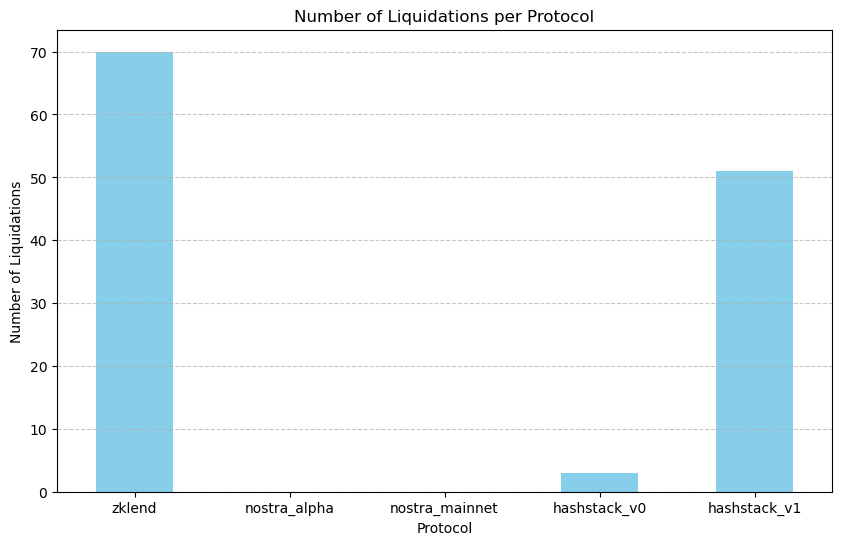

In [11]:
# Calculate the number of liquidations per protocol
liquidation_counts = liquidation_data['Protocol'].value_counts()

# Reindex liquidation_counts to ensure all protocols are included, filling missing ones with zero
liquidation_counts = liquidation_counts.reindex(PROTOCOLS, fill_value=0)

# Plot the number of liquidations per protocol
plt.figure(figsize=(10, 6))
liquidation_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Liquidations per Protocol')
plt.xlabel('Protocol')
plt.ylabel('Number of Liquidations')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Show the plot
plt.show()

# 1b. Number of liquidators per protocol

Unique Liquidators per Protocol:
Protocol
zklend            1
nostra_alpha      0
nostra_mainnet    0
hashstack_v0      1
hashstack_v1      1
Name: liquidator, dtype: int64
Cross protocol liquidators (Liquidators operating on multiple protocols): 0


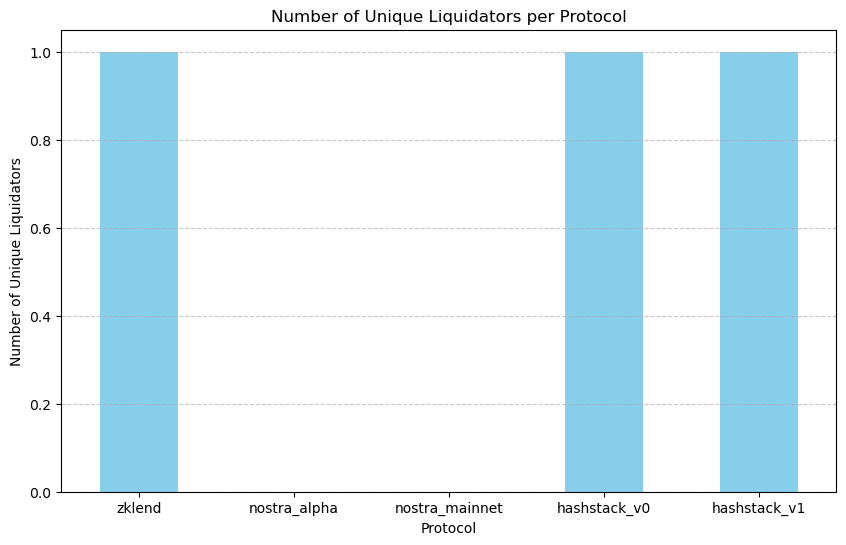

In [12]:
# Number of unique liquidators per protocol
# print('total data', list(liquidation_data['liquidator'].unique()))
unique_liquidators_per_protocol = liquidation_data.groupby('Protocol')['liquidator'].nunique()
unique_liquidators_per_protocol = unique_liquidators_per_protocol.reindex(PROTOCOLS, fill_value=0)

print("Unique Liquidators per Protocol:")
print(unique_liquidators_per_protocol)

# Liquidators operating on multiple protocols
liquidator_protocols = liquidation_data.groupby('liquidator')['Protocol'].nunique()
cross_protocol_liquidators = liquidator_protocols[liquidator_protocols > 1]
print("Cross protocol liquidators (Liquidators operating on multiple protocols):", cross_protocol_liquidators.size)

# Plot the number of unique liquidators per protocol
plt.figure(figsize=(10, 6))
unique_liquidators_per_protocol.plot(kind='bar', color='skyblue')
plt.title('Number of Unique Liquidators per Protocol')
plt.xlabel('Protocol')
plt.ylabel('Number of Unique Liquidators')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# 2. Loans liquidated by each liquidator

Number of Loans Liquidated by Each Liquidator:
0x4746c68f5f6d6bff7a16fdad6f543750bd6e46a7c00a9e5bb6820c86347fda0    70
0x1b862c518939339b950d0d21a3d4cc8ead102d6270850ac8544636e558fab68    51
0x3dcf5c72ba60eb7b2fe151032769d49dd3df6b04fa3141dffd6e2aa162b7a6e     3
Name: liquidator, dtype: int64


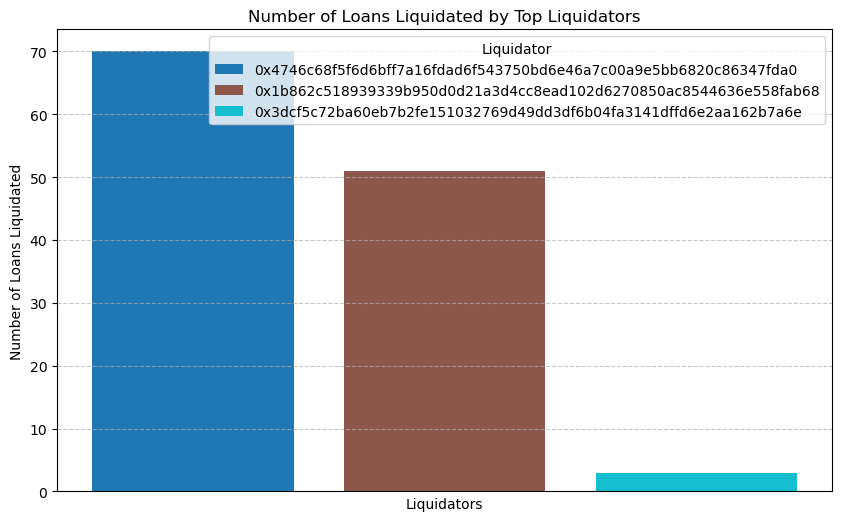

In [13]:
# Number of loans liquidated by each liquidator
loans_per_liquidator = liquidation_data['liquidator'].value_counts()
print("Number of Loans Liquidated by Each Liquidator:")
print(loans_per_liquidator)

# Plot the number of loans liquidated by top liquidators
top_liquidators = loans_per_liquidator.head(10)  # Display top 10 liquidators

# Create a color palette
colors = plt.get_cmap('tab10', len(top_liquidators))

# Create the bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(top_liquidators.index, top_liquidators.values, color=[colors(i) for i in range(len(top_liquidators))])

# Add legend
for bar, liquidator in zip(bars, top_liquidators.index):
    bar.set_label(liquidator)

plt.title('Number of Loans Liquidated by Top Liquidators')
plt.xlabel('Liquidators')
plt.ylabel('Number of Loans Liquidated')
plt.xticks([])  # Remove x-tick labels
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Liquidator')
plt.show()


# Finding USD price of the debt tokens using yfinance 

In [14]:
# Column names
column_names = ['timestamp', 'debt_token', 'liquidator', 'debt_face_amount', 'Protocol', 'transaction_hash']

# Concatenate filtered dataframes
liquidation_data = pd.concat(
    [filtered_df_zklend[column_names],
     filtered_df_hashstack_v0[column_names],
     filtered_df_hashstack_v1[column_names]], axis=0)

# Convert timestamp to datetime and extract the date part
liquidation_data['timestamp'] = pd.to_datetime(liquidation_data['timestamp'], unit='s')
liquidation_data['date'] = liquidation_data['timestamp'].dt.date

# Retrieve daily historical data for the past 5 years
token_prices = yf.download(["ETH-USD", "USDC-USD", "USDT-USD", "BTC-USD"], interval='1d', period='5y')

# Extract the adjusted close prices and rename date column 
adj_close_prices = token_prices['Adj Close'].reset_index()
adj_close_prices.rename(columns={'Date': 'date'}, inplace=True)

# Ensure both date columns are of the same type
liquidation_data['date'] = pd.to_datetime(liquidation_data['date'])
adj_close_prices['date'] = pd.to_datetime(adj_close_prices['date'])

# Merge all token prices into the liquidation_data dataframe on the date
liquidation_data = liquidation_data.merge(adj_close_prices, on='date', how='left')

# Define token info
token_info = {
    '0x49d36570d4e46f48e99674bd3fcc84644ddd6b96f7c741b1562b82f9e004dc7': ["ETH", 18],
    '0x53c91253bc9682c04929ca02ed00b3e423f6710d2ee7e0d5ebb06f3ecf368a8': ["USDC", 6],
    '0x68f5c6a61780768455de69077e07e89787839bf8166decfbf92b645209c0fb8': ["USDT", 6],
    '0x3fe2b97c1fd336e750087d68b9b867997fd64a2661ff3ca5a7c771641e8e7ac': ["BTC", 8]
}

# Function to convert hex string to integer and calculate USD value
def get_usd_amount(row: pd.Series) -> float:
    """
    Convert hex string to integer, calculate the USD value based on token price.

    Parameters:
    row (pd.Series): A row from the DataFrame containing liquidation event data.

    Returns:
    float: The USD value of the debt amount.
    """
    token = row['debt_token']
    decimal = token_info[token][1]
    face_amount = int(row['debt_face_amount'], 0) / (10**decimal)
    token_symbol = token_info[token][0]
    token_price = row[f'{token_symbol}-USD']
    
    return face_amount * token_price if token_price else None

# Apply the function to the dataframe and create a new column
liquidation_data['debt_usd_value'] = liquidation_data.apply(get_usd_amount, axis=1)

[*********************100%%**********************]  4 of 4 completed

1 Failed download:
['USDC-USD']: ConnectionError(ProtocolError('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None)))


# 3. Average liquidated debt

In [15]:
# Average liquidated debt amount across all liquidations
average_debt_all = liquidation_data['debt_usd_value'].mean()
print("Average Liquidated Debt Amount (All):", average_debt_all)

# Average liquidated debt amount per protocol
average_debt_per_protocol = liquidation_data.groupby('Protocol')['debt_usd_value'].mean()
# List all protocols
average_debt_per_protocol = average_debt_per_protocol.reindex(PROTOCOLS, fill_value=0)

print("\nAverage Liquidated Debt Amount per Protocol:")
print(average_debt_per_protocol)

# Average liquidated debt amount per token
average_debt_per_token = liquidation_data.groupby('debt_token')['debt_usd_value'].mean()

# Map token addresses to names (assuming token_info values are lists with the first element as the token name)
avg_token_debt = {token_info[token][0]: average_debt_per_token[token] for token in average_debt_per_token.index}

print("\Average Liquidated Debt Amount per Token:")
for token_name, debt in avg_token_debt.items():
    print(f"{token_name}: {debt}")

Average Liquidated Debt Amount (All): 238.44279249429513

Average Liquidated Debt Amount per Protocol:
Protocol
zklend              3.993439
nostra_alpha        0.000000
nostra_mainnet      0.000000
hashstack_v0       30.866037
hashstack_v1      599.959290
Name: debt_usd_value, dtype: float64
\Average Liquidated Debt Amount per Token:
BTC: 27.395932320996096
ETH: 181.8002608111926
USDC: nan
USDT: 1026.2638138713598


# 4. Total liquidated debt

In [16]:
# Total liquidated debt amount across all liquidations
total_debt_all = liquidation_data['debt_usd_value'].sum()
print("Total Liquidated Debt Amount (All):", total_debt_all)

# Total liquidated debt amount per protocol
total_debt_per_protocol = liquidation_data.groupby('Protocol')['debt_usd_value'].sum()
# List all protocols
total_debt_per_protocol = total_debt_per_protocol.reindex(PROTOCOLS, fill_value=0)

print("\nTotal Liquidated Debt Amount per Protocol:")
print(total_debt_per_protocol)

# Total liquidated debt amount per token
total_debt_per_token = liquidation_data.groupby('debt_token')['debt_usd_value'].sum()

# Map token addresses to names (assuming token_info values are lists with the first element as the token name)
token_debt = {token_info[token][0]: total_debt_per_token[token] for token in total_debt_per_token.index}

print("\nTotal Liquidated Debt Amount per Token:")
for token_name, debt in token_debt.items():
    print(f"{token_name}: {debt}")


Total Liquidated Debt Amount (All): 20029.19456952079

Total Liquidated Debt Amount per Protocol:
Protocol
zklend              199.671957
nostra_alpha          0.000000
nostra_mainnet        0.000000
hashstack_v0         30.866037
hashstack_v1      19798.656576
Name: debt_usd_value, dtype: float64

Total Liquidated Debt Amount per Token:
BTC: 54.79186464199219
ETH: 13816.819821650637
USDC: 0.0
USDT: 6157.5828832281595


# Visualization of Average and Total Liquidated Debt Amount per protocol


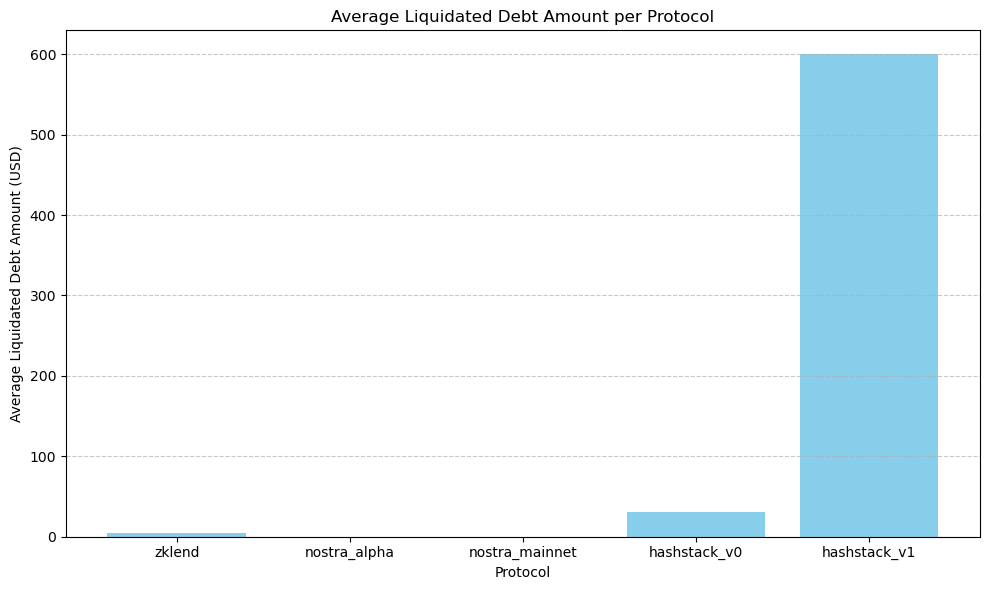

<Figure size 1000x600 with 0 Axes>

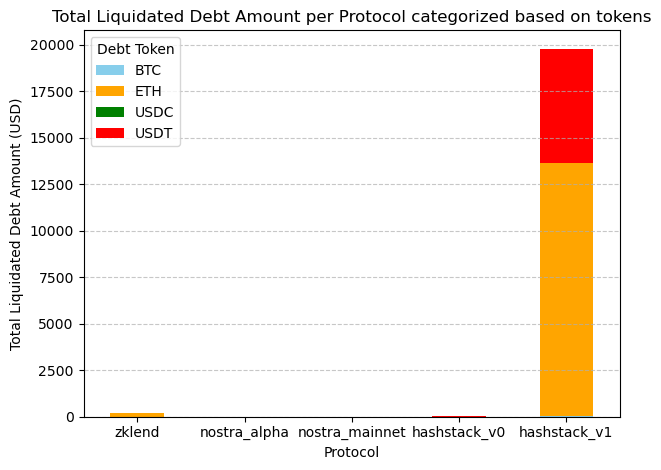

In [17]:
# Calculate the average liquidated debt amount per protocol
average_debt_per_protocol = liquidation_data.groupby('Protocol')['debt_usd_value'].mean()
average_debt_per_protocol = average_debt_per_protocol.reindex(PROTOCOLS, fill_value=0)

# Calculate the total liquidated debt amount per protocol
total_debt_per_protocol = liquidation_data.groupby('Protocol')['debt_usd_value'].sum()
total_debt_per_protocol = total_debt_per_protocol.reindex(PROTOCOLS, fill_value=0)

# Plot average liquidated debt amount per protocol
plt.figure(figsize=(10, 6))
plt.bar(average_debt_per_protocol.index, average_debt_per_protocol.values, color='skyblue')
plt.title('Average Liquidated Debt Amount per Protocol')
plt.xlabel('Protocol')
plt.ylabel('Average Liquidated Debt Amount (USD)')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Aggregate the data by Protocol and debt_token
aggregated_data = liquidation_data.groupby(['Protocol', 'debt_token'])['debt_usd_value'].sum().unstack().fillna(0)
# Ensure all protocols are included in the index
aggregated_data = aggregated_data.reindex(PROTOCOLS, fill_value=0)

# prepares a dict of token addr to name map
token_names = {key: value[0] for key, value in token_info.items()}
# Rename columns to human-readable token names
aggregated_data.rename(columns=token_names, inplace=True)
# Plot stacked bar plot
plt.figure(figsize=(10, 6))
aggregated_data.plot(kind='bar', stacked=True, color=['skyblue', 'orange', 'green', 'red'])
plt.title('Total Liquidated Debt Amount per Protocol categorized based on tokens')
plt.xlabel('Protocol')
plt.ylabel('Total Liquidated Debt Amount (USD)')
plt.legend(title='Debt Token')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Total and average debts liquidated per token

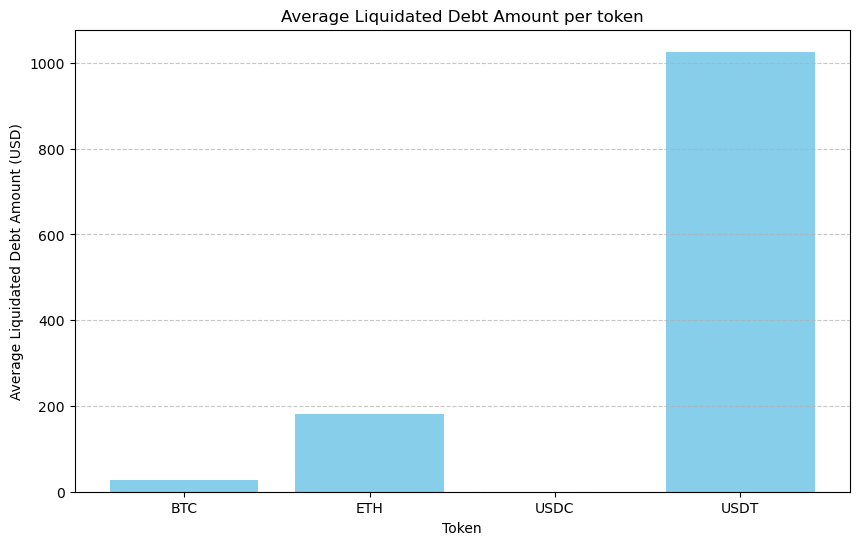

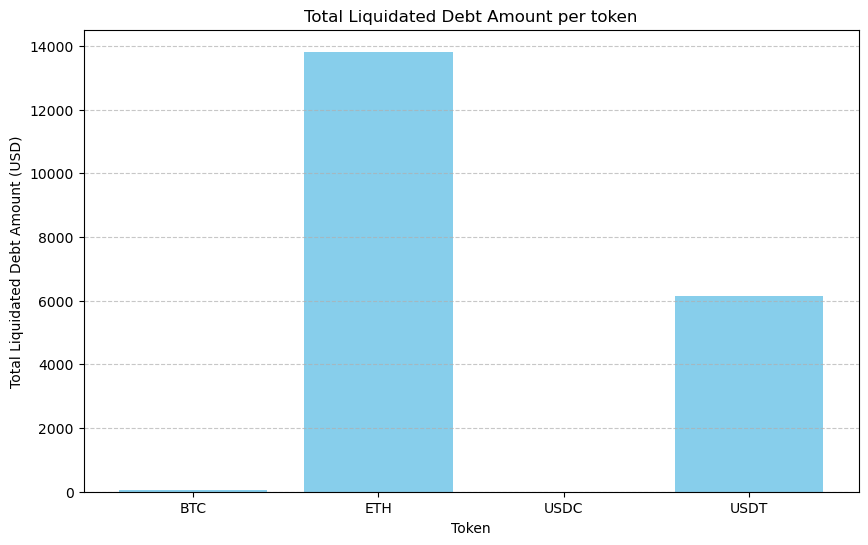

In [18]:
# Calculate the average liquidated debt amount per protocol
average_debt_per_protocol = liquidation_data.groupby('debt_token')['debt_usd_value'].mean()
token_names_array = [token_names[token] for token in average_debt_per_protocol.index]

# Plot average liquidated debt amount per protocol
plt.figure(figsize=(10, 6))
plt.bar(token_names_array, average_debt_per_protocol.values, color='skyblue')
plt.title('Average Liquidated Debt Amount per token')
plt.xlabel('Token')
plt.ylabel('Average Liquidated Debt Amount (USD)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# Calculate the total liquidated debt amount per protocol
total_debt_per_protocol = liquidation_data.groupby('debt_token')['debt_usd_value'].sum()

# Plot total liquidated debt amount per protocol
plt.figure(figsize=(10, 6))
plt.bar(token_names_array, total_debt_per_protocol.values, color='skyblue')
plt.title('Total Liquidated Debt Amount per token')
plt.xlabel('Token')
plt.ylabel('Total Liquidated Debt Amount (USD)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Observations

1. **Frequency of Liquidations**: Over 3 days span, Zklend recorded 70 liquidation events out of the first 100,000 events. In contrast, Hashstack V1, covering a period from 2023-11-30 to 2024-05-25, there are 51 liquidation events.

2. **Total Liquidation Amounts**: The highest liquidation amounts in USD were observed in Hashstack V1. This suggests that although liquidations were less frequent in Hashstack V1, the events that did occur involved larger sums of assets.

3. **Token-Specific Liquidations**: In terms of token-specific liquidation amounts, both ZKlend and HashstackV1 showed the largest liquidation value in USD were primarily from ETH and USDC. Zklend's short-term data indicated that ETH and USDC liquidations dominated, followed by USDT, followed by BTC. Similarly, Hashstack V1 also followed this trend but with higher USD value involved.
